In [0]:
!pip install gdelt
        

     |████████████████████████████████| 778kB 4.8MB/s 


In [0]:
# start the Spark context
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.3.2/spark-2.3.2-bin-hadoop2.7.tgz
!tar xf spark-2.3.2-bin-hadoop2.7.tgz
!pip install -q pyspark

tar: spark-2.3.2-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
     |████████████████████████████████| 215.6MB 121kB/s 
     |████████████████████████████████| 204kB 42.8MB/s 


In [0]:
import pyspark
from pyspark import SparkConf, SparkContext
import os
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64/"

sc = SparkContext("local[2]", "Demo")
conf = SparkConf().setMaster("local[*]").set("spark.executor.memory", "1g")



def dbg(x):
  """ A helper function to print debugging information on RDDs """
  if isinstance(x, pyspark.RDD):
    print([(t[0], list(t[1]) if 
            isinstance(t[1], pyspark.resultiterable.ResultIterable) else t[1])
           if isinstance(t, tuple) else t
           for t in x.take(100)])
  else:
    print(x)
    


In [0]:
# get EventCode from websit => looking for crime type event
!wget -q -O eventcodes.txt https://www.gdeltproject.org/data/lookups/CAMEO.eventcodes.txt
f = open("eventcodes.txt", "r")
event_line = f.read().splitlines()[1:]

# get countryCAMEO from websit => looking for abbreviation of countries
!wget -q -O countryCAMEO.txt https://www.gdeltproject.org/data/lookups/CAMEO.country.txt
f1 = open("countryCAMEO.txt", "r")
countryCAMEO = f1.read().splitlines()[1:]

# get countryFIPS from websit => Different edition of abbreviation of area 
!wget -q -O countryFIPS.txt  https://www.gdeltproject.org/data/lookups/FIPS.country.txt
f2 = open("countryFIPS.txt", "r")
countryFIPS = f2.read().splitlines()[1:]





In [0]:
import gdelt
import json
import numpy
import time


def CountryCode_FIPS_CAMEO():
  #Convert CAMEO country code to FIPS country code, make sure 
  #its Synchronize (New Zealand => NZ => NZL)
  
  countryCode = {}
  for i in countryCAMEO:
    for j in countryFIPS:
      if i.split('\t')[1] == j.split('\t')[1]:
        countryCode.update(dict([(j.split('\t')[0],i.split('\t')[0])]))
        
  return countryCode


def CrimeEventCode():
  #Create a Crime Event list like a small database, collecting the
  #Event relate to Crime event
  
  crime_events = []
  lines = []
  for i in event_line:
    lines.append(i.split('\t'))
  for j in lines:
    if j[0].startswith('091') or j[0].startswith('092') :
      crime_events.append(j[0])

    if j[0].startswith('1121') or j[0].startswith('1122') or j[0].startswith('1123') :
      crime_events.append(j[0])
    if j[0].startswith('18'):
      if j[0] != '18':
        crime_events.append(j[0])
    if j[0].startswith('19'):
      if j[0] != '19':
        crime_events.append(j[0])  
    if j[0].startswith('20'):
      if j[0] != '20':
        crime_events.append(j[0])
  return crime_events
  

def ValidInf(y, countrySelect):
  #Using feature of cirime event to generate a group criteria
  #and convert to Jaccard metrix 
  
  saveValidInf = []
  
  crime_events = CrimeEventCode()
  countryCode = CountryCode_FIPS_CAMEO()
  

  for z in range(len(y)): 
    initMetric = numpy.zeros(4,dtype = int)
    if y[z]["ActionGeo_CountryCode"] == countrySelect:
      if y[z]["AvgTone"] < 0:
        initMetric[0] = 1
      if y[z]["QuadClass"] >= 3:
        initMetric[1] = 1
      if y[z]["GoldsteinScale"] != None and y[z]["GoldsteinScale"] <= 0:
        initMetric[2] = 1
      if y[z]["EventCode"] in crime_events:
        initMetric[3] = 1
      
      saveValidInf += [((y[z]["GLOBALEVENTID"],y[z]["SOURCEURL"]),initMetric)]
    
  return saveValidInf

  
def getJaccardDistance(initMetric):
  #Calculate Jaccard Distance using (1-similiarity)
  
  finalMetric = numpy.array([1,1,1,1])
  union = 0
  intersection = 0
  for i in range(len(initMetric)):
    if initMetric[i] == 1 or finalMetric[i] == 1:
      union += 1
    if finalMetric[i] == 1 and initMetric[i] == 1:
      intersection += 1
      
  JaccardSimilarty = intersection/union
  JaccardDistance = 1 - JaccardSimilarty
  return float(JaccardDistance)



def dairyCrime(saveValidInf):
  #analying Crime event each day, and collecting the information we want
  
  gdeltInf = sc.parallelize(saveValidInf)
  JaccardEvent = gdeltInf.map(lambda x : (x[0],getJaccardDistance(x[1]))).sortBy(lambda x : x[1],True)
  
  
  JaccardDistanceEvent = (JaccardEvent.map(lambda x: (x[1],1))
                                      .reduceByKey(lambda x, y: x+y)
                                      .sortBy(lambda x: x[0],True))
  
  traceTop20CrimeNews = (JaccardEvent.filter(lambda x: x[1] < 0.5)   #make sure the distance smaller than 0.5
                                     .map(lambda x: (x[0][1],1))
                                     .reduceByKey(lambda x,y: x+y)
                                     .sortBy(lambda x: x[1],False)
                                     .take(20))
  
  totalEvent = JaccardEvent.count()
  percentageJacDistance = (JaccardDistanceEvent.map(lambda x: (x[0],x[1]/totalEvent)))

  return JaccardEvent,JaccardDistanceEvent,traceTop20CrimeNews



def collectGDELTdata(year, month, day):
  #using gdtlepy process GDELT database
  
  gd2 = gdelt.gdelt(version=2)
  results = gd2.Search(['{} {} {}'.format(year, month, day)],table='events',coverage=True,output='json')
  data = json.loads(results)
  print("{} {} {} read successful".format(year, month, day))
  day+=1
  return data
  
  
def main(year, month ,day, countrySelect):
  #run all funtions and downloading a period time of GDELT database
  recordJaccardEvent = []
  recordJaccardDistance = []
  recordTop20CrimeNews = []
 
  
  while day <= 30:
    data = collectGDELTdata(year, month ,day)
    ValidData = ValidInf(data, countrySelect)
    
    recordJaccardEvent.append(dairyCrime(ValidData)[0].collect())
    recordJaccardDistance.append(dairyCrime(ValidData)[1].collect())
    recordTop20CrimeNews.append(dairyCrime(ValidData)[2])
    
    day+=1
    
  return recordJaccardEvent,recordJaccardDistance,recordTop20CrimeNews

In [0]:
# main(year, month ,day, countrySelect)[0]  
#get : (830908525,'https://www.kiro7.com/news/trending-now/reports-multiple-people-injured-in-new-zealand-mosque-shooting/930716658'),0.0)

# main(year, month ,day, countrySelect)[1]  
#get : [(0.0, 1276),(0.19999999999999996, 1441),(0.4, 982),(0.6, 2103),(0.8, 1787),(1.0, 173)]

# main(year, month ,day, countrySelect)[2]  
#get : URLS      Top 20 CrimeNews

In [0]:
import matplotlib.pyplot as plt
 #record all Jaccard distance less than 0.5 event


def analyCrimeEventDay(testingInf):
  #accept list (day and number of crime evnets)
  periodCrimeEvent = []
  for i in range(len(testingInf)):
    collect = []
    for ii in testingInf[i]:
      if float(ii[0]) <= 0.51:
        collect.append(float(ii[1]))
    periodCrimeEvent.append((i+1,sum(collect)))
  return periodCrimeEvent
 
  
def createColumnChart(currentCrimeEvent,year,month,day):
  #Crime events vs Days
  
  analysisPlot = sc.parallelize(analyCrimeEventDay(currentCrimeEvent))


  WIDTH = 13 
  LINE = ('+' + ''.center(WIDTH, '-') +
          '+' + ''.center(WIDTH, '-') +
          '+')
  print(LINE)
  print('|' + 'Day'.center(WIDTH, ' ') +
        '|' + 'Crime Events'.center(WIDTH, ' ') +
        '|')
  print(LINE)
  for i in analysisPlot.collect():
    print('|' + "{} {} {}".format(year, month, str(day-1 + int(i[0]))).center(WIDTH, ' ') +
          '|' + str(int(i[1])).center(WIDTH, ' ') +
          '|')
  print(LINE)  



  dirayCrimeDays   = analysisPlot.map(lambda x : x[0]).collect()
  dirayCrimeEvents = analysisPlot.map(lambda x : x[1]).collect()



  fig = plt.figure(figsize=(12.5,5), facecolor='white', edgecolor='white')
  plt.axis([0, len(dirayCrimeDays)+3, 0, max(dirayCrimeEvents)+400])
  plt.grid(b=True, which='major', axis='y')
  plt.xlabel('Days')
  plt.ylabel('Crime Events')
  plt.bar(dirayCrimeDays, dirayCrimeEvents)


In [0]:
def createPieChart(currentCrimeEvent):
  # Jaccard distance percentage each day
  
  count = 0
  while count < len(currentCrimeEvent[1]):
    pieC = sc.parallelize(currentCrimeEvent[1][count])

    labels = pieC.map(lambda x: x[0]).collect()
    fracs = pieC.map(lambda x: x[1]).collect()

    def pie_pct_format(value):
        return '%.0f%%' % value

    fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
    colors = ['red', 'tomato', 'gold', 'aqua', 'lightblue','lightskyblue']
    explode = (0., 0., 0., 0., 0.)
    patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                             explode=explode, autopct=pie_pct_format,
                                                shadow=False, startangle=125)
    for text, autotext in zip(texts, autotexts):
        if autotext.get_text() == '':
            text.set_text('')  # If the slice is small to fit, don't show a text label
    plt.legend(labels, loc=(0.80, -0.1), shadow=True)
    count  += 1

In [0]:
### RUN CAREFULLY !!!!!!!!!!!!!!!!!!!! ###########
#3.15 CHRISTCHURCH CRIME EVENT 
year, month ,day = 2019, 3, 11
All_main_Chritchurch = main(year, month ,day, "NZ")
### RUN CAREFULLY !!!!!!!!!!!!!!!!!!!! ###########

2019 3 11 read successful
2019 3 12 read successful


/usr/local/lib/python3.6/dist-packages/gdelt/parallel.py:67: UserWarning: GDELT does not have a url for date time 20190313030000
  warnings.warn(message)
/usr/local/lib/python3.6/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20190313030000
  warnings.warn(message)


2019 3 13 read successful
2019 3 14 read successful
2019 3 15 read successful
2019 3 16 read successful
2019 3 17 read successful
2019 3 18 read successful
2019 3 19 read successful
2019 3 20 read successful
2019 3 21 read successful
2019 3 22 read successful
2019 3 23 read successful
2019 3 24 read successful
2019 3 25 read successful
2019 3 26 read successful
2019 3 27 read successful
2019 3 28 read successful
2019 3 29 read successful
2019 3 30 read successful


In [0]:
saveURL = []
WIDTH = 3
for i in All_main_Chritchurch[2]:
     for ii in i:
      saveURL.append(ii)

topNews = sc.parallelize(saveURL)

top10News = topNews.sortBy(lambda x : x[1],False).take(10)  #Show 10 most mentioned news in period of time

print("|Christchurch mosque shootings news| ")

for ii in range(1,len(top10News)+1):
  print(
      "|" + str(int(ii)).center(WIDTH, ' '), 
      "|" + top10News[ii-1][0]       
       )

|Christchurch mosque shootings news| 
| 1  |https://www.ny1.com/nyc/all-boroughs/ap-online/2019/03/17/the-latest-authorities-to-begin-release-of-nz-attack-bodies
| 2  |https://www.ksl.com/article/46512432/the-latest-more-details-emerge-on-mosque-shooting-suspect
| 3  |https://www.dailymail.co.uk/news/article-6823785/Sermon-called-hateful-rhetoric-Sunday-Trumps-went-church.html
| 4  |http://www.fbherald.com/news/the-latest-new-zealand-s-biggest-gun-show-is-canceled/article_7698279a-8ed2-5bc0-9a1a-9cbd450929fc.html
| 5  |https://www.couriermail.com.au/news/world/new-zealand-prime-minister-jacinda-ardern-seeks-advice-on-deportation-options-for-accused-brenton-tarrant/news-story/3e0c76c98ad556e8dd33ee42a55fed42?nk=c8219270406343852a5ac0731280062a-1552868265
| 6  |https://www.nzherald.co.nz/nz/news/article.cfm?c_id=1&objectid=12215220
| 7  |https://www.nzherald.co.nz/nz/news/article.cfm?c_id=1&objectid=12213106
| 8  |http://www.scoop.co.nz/stories/HL1903/S00123/new-post-christchurch-terror-

+-------------+-------------+
|     Day     | Crime Events|
+-------------+-------------+
|  2019 3 11  |     297     |
|  2019 3 12  |     330     |
|  2019 3 13  |     437     |
|  2019 3 14  |     402     |
|  2019 3 15  |     4626    |
|  2019 3 16  |     3802    |
|  2019 3 17  |     2969    |
|  2019 3 18  |     3549    |
|  2019 3 19  |     2467    |
|  2019 3 20  |     2249    |
|  2019 3 21  |     2149    |
|  2019 3 22  |     1986    |
|  2019 3 23  |     1157    |
|  2019 3 24  |     840     |
|  2019 3 25  |     1265    |
|  2019 3 26  |     1057    |
|  2019 3 27  |     898     |
|  2019 3 28  |     930     |
|  2019 3 29  |     822     |
|  2019 3 30  |     506     |
+-------------+-------------+


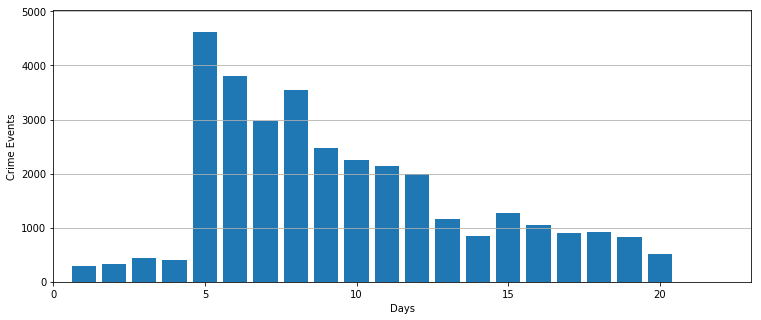

In [0]:
#3.15 CHRISTCHURCH CRIME EVENT 
year, month ,day = 2019, 3, 11
CHC_CrimeEvent = All_main_Chritchurch[1]  #list of data Days vs Crime Events (Jaccard distance smaller than 0.5)
createColumnChart(CHC_CrimeEvent,year,month,day)  #create a column Chart

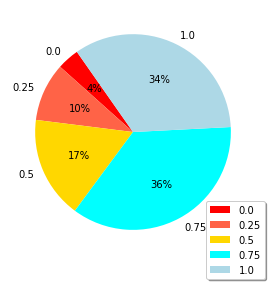

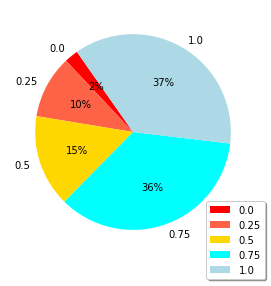

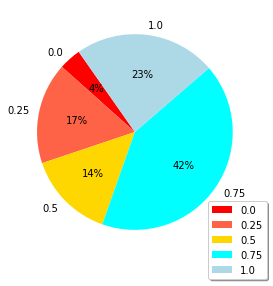

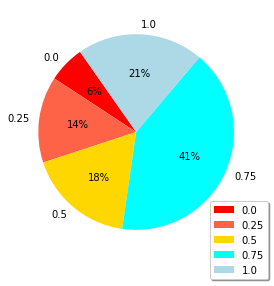

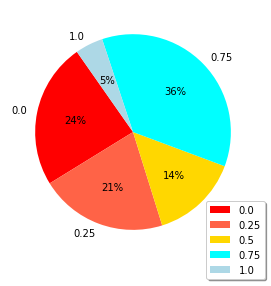

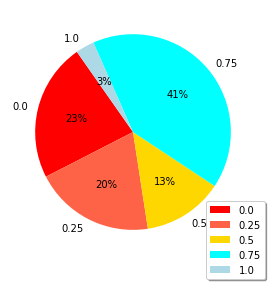

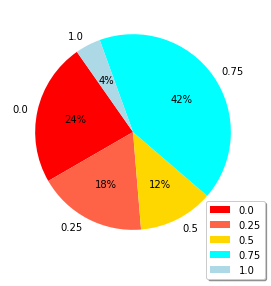

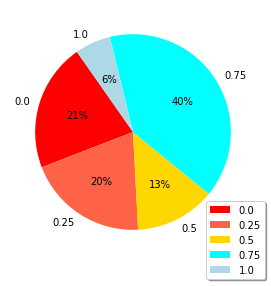

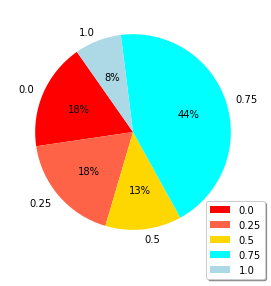

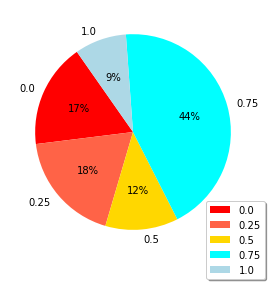

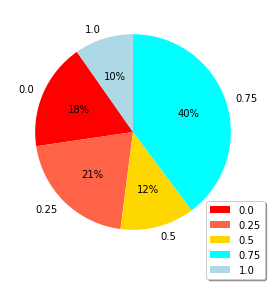

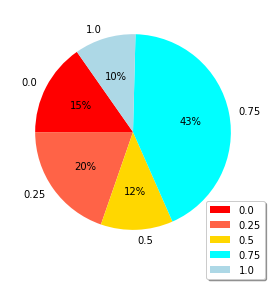

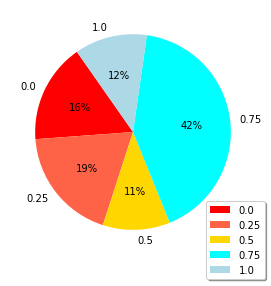

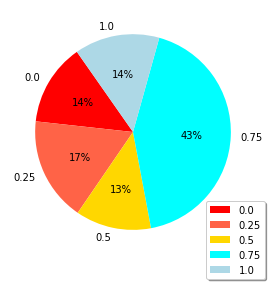

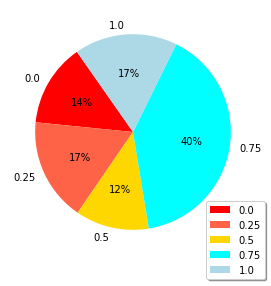

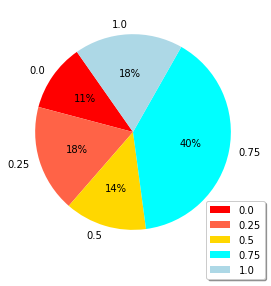

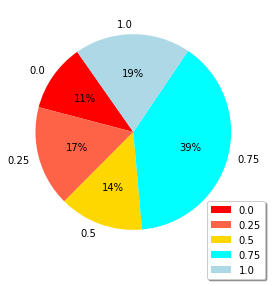

In [0]:
createPieChart(All_main_Chritchurch)

In [0]:
### RUN CAREFULLY !!!!!!!!!!!!!!!!!!!! ###########
#4.21 Sri Lanka CRIME EVENT
#4.21 Sri Lanka CRIME EVENT

year, month ,day = 2019, 4, 19
All_main_Sri_Lanka = main(year, month ,day, "CE")
### RUN CAREFULLY !!!!!!!!!!!!!!!!!!!! ###########

2019 4 19 read successful
2019 4 20 read successful
2019 4 21 read successful
2019 4 22 read successful
2019 4 23 read successful
2019 4 24 read successful
2019 4 25 read successful
2019 4 26 read successful
2019 4 27 read successful
2019 4 28 read successful
2019 4 29 read successful
2019 4 30 read successful


[[(0.0, 34), (0.25, 75), (0.5, 53), (0.75, 145), (1.0, 53)], [(0.0, 18), (0.25, 60), (0.5, 61), (0.75, 160), (1.0, 53)], [(0.0, 1111), (0.25, 1370), (0.5, 937), (0.75, 2163), (1.0, 80)], [(0.0, 1637), (0.25, 1994), (0.5, 1318), (0.75, 2831), (1.0, 118)], [(0.0, 1358), (0.25, 1789), (0.5, 1118), (0.75, 2444), (1.0, 138)], [(0.0, 1020), (0.25, 1207), (0.5, 992), (0.75, 1849), (1.0, 80)], [(0.0, 737), (0.25, 989), (0.5, 834), (0.75, 1723), (1.0, 132)], [(0.0, 740), (0.25, 915), (0.5, 710), (0.75, 1543), (1.0, 118)], [(0.0, 841), (0.25, 714), (0.5, 504), (0.75, 1105), (1.0, 49)], [(0.0, 837), (0.25, 724), (0.5, 482), (0.75, 1096), (1.0, 45)], [(0.0, 662), (0.25, 842), (0.5, 470), (0.75, 1112), (1.0, 93)], [(0.0, 424), (0.25, 620), (0.5, 383), (0.75, 895), (1.0, 96)]]
+-------------+-------------+
|     Day     | Crime Events|
+-------------+-------------+
|  2019 4 19  |     162     |
|  2019 4 20  |     139     |
|  2019 4 21  |     3418    |
|  2019 4 22  |     4949    |
|  2019 4 23  | 

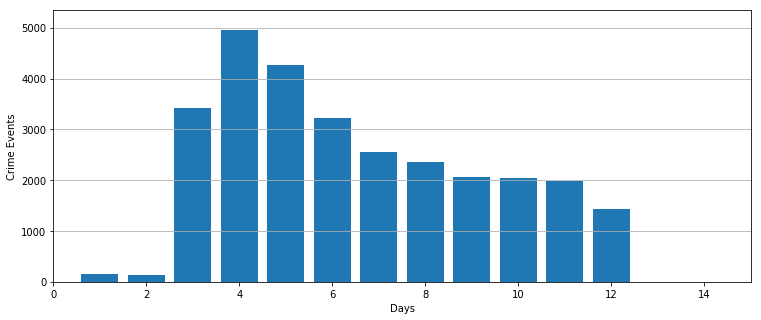

In [0]:
#4.21 Sri Lanka CRIME EVENT
#4.21 Sri Lanka CRIME EVENT

year, month ,day = 2019, 4, 19
CE_CrimeEvent = All_main_Sri_Lanka[1]
print(CE_CrimeEvent)    # Jaccad distance and number of events 
createColumnChart(CE_CrimeEvent,year, month ,day) 

In [0]:
saveURL = []
WIDTH = 3
for i in All_main_Sri_Lanka[2]:
     for ii in i:
      saveURL.append(ii)

topNews = sc.parallelize(saveURL)

top10News = topNews.sortBy(lambda x : x[1],False).take(10)

print("|Sri Lanka Easter bombings news| ")

for ii in range(1,len(top10News)+1):
  print(
      "|" + str(int(ii)).center(WIDTH, ' '), 
      "|" + top10News[ii-1][0]       
       )

|Sri Lanka Easter bombings news| 
| 1  |https://www.trtworld.com/asia/country-on-alert-for-more-acts-of-terror-sri-lanka-attacks-26063/amp/
| 2  |https://www.trtworld.com/asia/bodies-of-15-found-after-gun-battle-on-sri-lanka-s-eastern-coast-26063
| 3  |https://www.whec.com/national/the-latest-sri-lanka-hospital-says-blasts-kill-at-least-30/5324399/
| 4  |http://www.newageislam.com/islamic-world-news/new-age-islam-news-bureau/islamic-state-claims-responsibility,-sri-lanka-bomb-attacks-were-revenge-for-new-zealand-mosque-killings/d/118403
| 5  |http://www.ncnewsonline.com/news/national/the-latest-social-media-services-blocked-in-sri-lanka/article_205993e9-65b4-5e6b-8353-781d82b3d9b5.html
| 6  |http://www.lankaweb.com/news/items/2019/04/23/hostility-and-violence-within-the-muslim-community-of-sri-lanka/
| 7  |http://www.newageislam.com/islamic-world-news/new-age-islam-news-bureau/sri-lanka-s-muslim-community-should-not-be-blamed-for-the-easter-sunday-suicide-bombings--the-archbishop-of-co

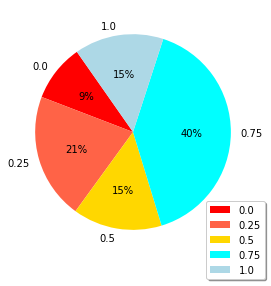

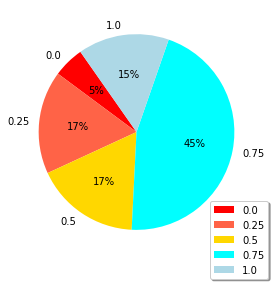

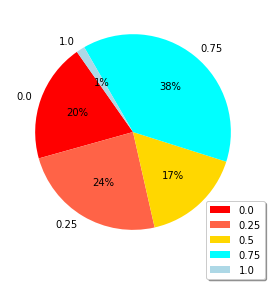

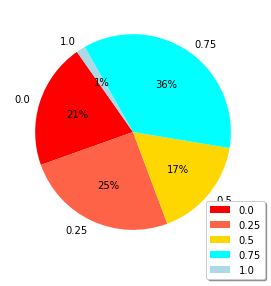

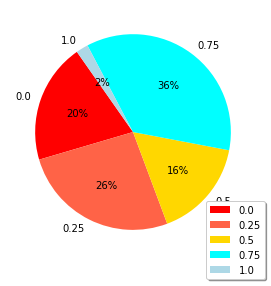

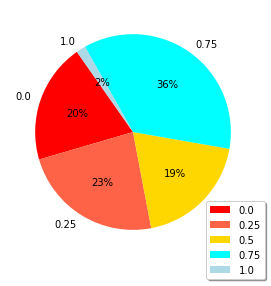

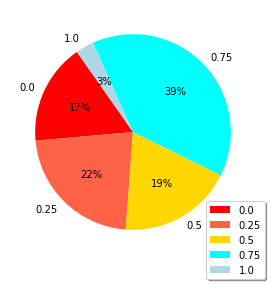

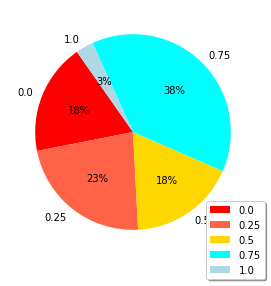

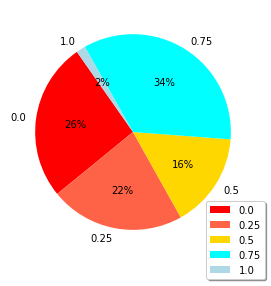

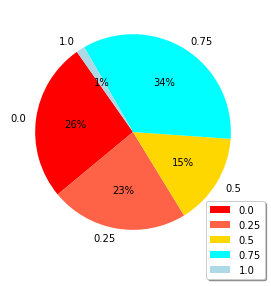

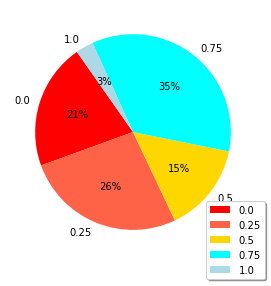

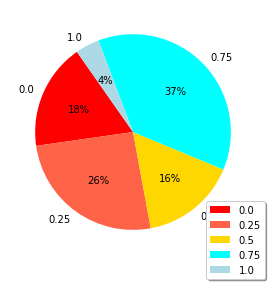

In [0]:
createPieChart(All_main_Sri_Lanka)

In [0]:
### RUN CAREFULLY !!!!!!!!!!!!!!!!!!!! ###########
#2017.10.1 US CRIME EVENT
#2017.10.1 US CRIME EVENT  Las Vegas shooting

year, month ,day = 2017, 10, 1
All_main_US = main(year, month ,day, "US")
### RUN CAREFULLY !!!!!!!!!!!!!!!!!!!! ###########

+-------------+-------------+
|     Day     | Crime Events|
+-------------+-------------+
|  2017 10 1  |     1883    |
|  2017 10 2  |     7476    |
|  2017 10 3  |     8442    |
|  2017 10 4  |     6180    |
|  2017 10 5  |     5875    |
|  2017 10 6  |     4716    |
|  2017 10 7  |     3440    |
|  2017 10 8  |     2803    |
|  2017 10 9  |     3848    |
|  2017 10 10 |     5378    |
|  2017 10 11 |     5242    |
|  2017 10 12 |     5650    |
|  2017 10 13 |     5380    |
|  2017 10 14 |     3369    |
|  2017 10 15 |     2809    |
|  2017 10 16 |     4311    |
|  2017 10 17 |     5262    |
|  2017 10 18 |     5720    |
|  2017 10 19 |     5978    |
|  2017 10 20 |     5524    |
+-------------+-------------+


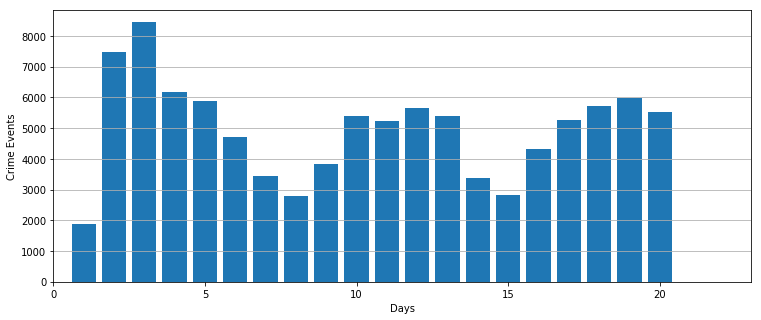

In [0]:
#2017.10.1 US CRIME EVENT
#2017.10.1 US CRIME EVENT

year, month ,day = 2017, 10, 1
US_CrimeEvent = All_main_US[1]
createColumnChart(US_CrimeEvent, year, month ,day) 

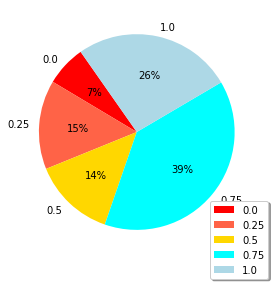

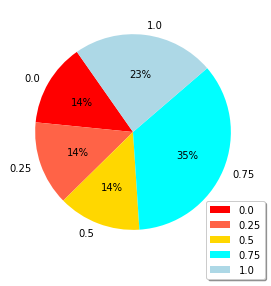

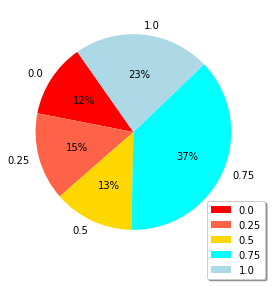

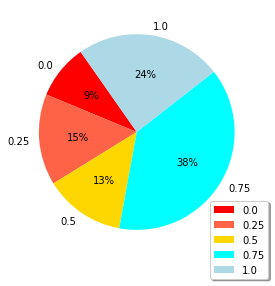

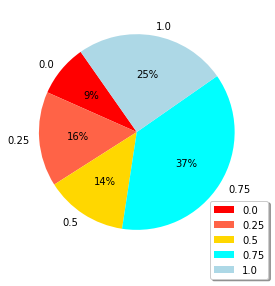

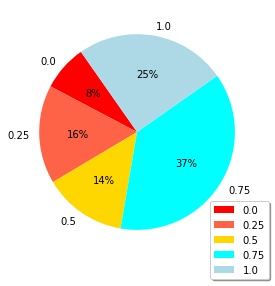

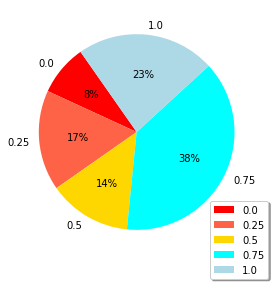

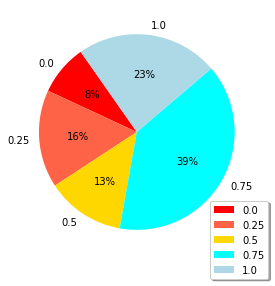

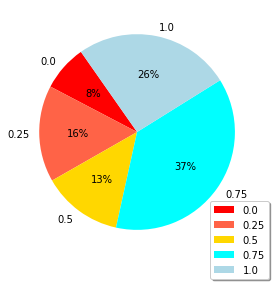

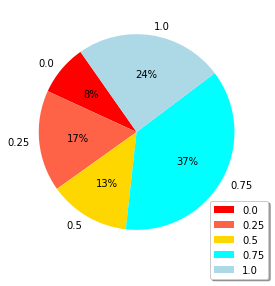

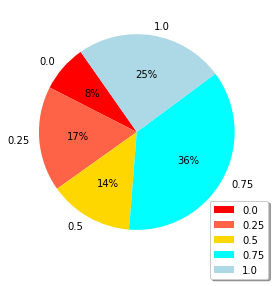

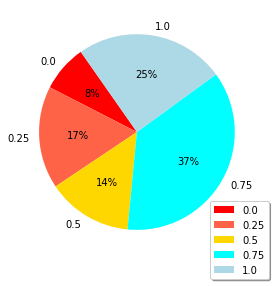

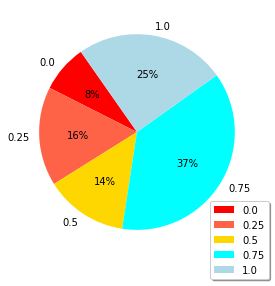

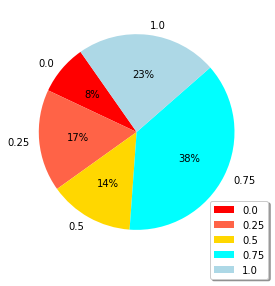

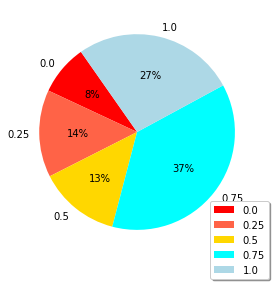

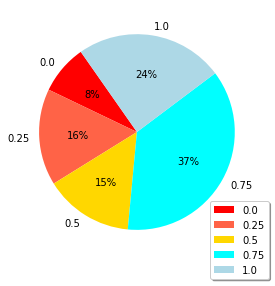

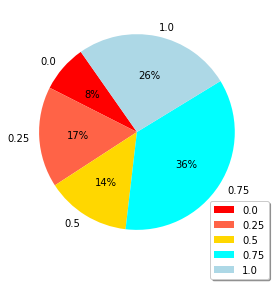

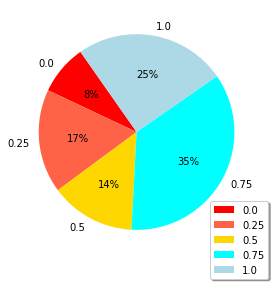

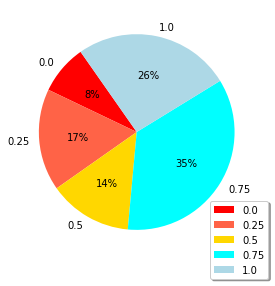

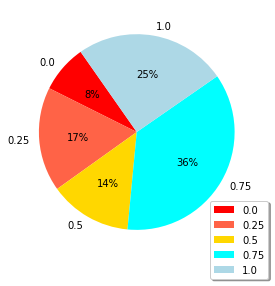

In [0]:
createPieChart(All_main_US)